In [5]:
#------------------------Package Loading----------------------------------#
import numpy as np 
from xarray import open_dataset as xr_open
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cft
import nc_time_axis
from itertools import combinations as com
from operator import itemgetter as iget
from pandas import DataFrame as pddf
#-------------------------------------------------------------------------#


#------------------------Function Defintion-------------------------------#
def Cooling_Engine(file,grid,radius,change,surf):
    
    lat = surf['lat'].values
    lon = surf['lon'].values

    for pair in grid:
        center_lat = pair[0]
        center_lon = pair[1]

        for elem in lat:
            for elem2 in lon:

                if ((elem >= center_lat-radius and elem <= center_lat+radius)\
                    and (elem2 >= center_lon-radius and elem2 <= center_lon+radius)):

                    if (elem >= 0):
                        lat_check = elem - center_lat
                    elif (elem < 0):
                        lat_check = abs(elem) + center_lat
                    lon_check = abs(elem2) - center_lon

                    if ((lat_check**2+lon_check**2) <= radius**2):
                        lt = int(np.where(lat == elem)[0][0])
                        ln = int(np.where(lon == elem2)[0][0])
                        file[:,lt,ln] = file[:,lt,ln] - abs(change)
                                  
def Configure_Plot(surf,gtitle,cbtitle,color_scheme):
    
    lon_b = np.linspace(0, 360, 288)
    lat_b = np.linspace(-90, 90,192) 
    fig = plt.figure(figsize=[15,9])
    ax = plt.axes(projection=ccrs.Robinson())
    ax.add_feature(cft.LAND, zorder=100, edgecolor='k')
    ax.coastlines()
    plt.pcolormesh(lon_b, lat_b, surf, cmap=color_scheme, transform=ccrs.PlateCarree())
    cb = plt.colorbar(shrink=0.6)
    plt.title(gtitle, fontsize=25)
    cb.set_label(cbtitle)

def CSV_Ref_Gen(size,ref_num,clist):
    trues_list = [0]*(size**2+1)
    trues_list[0]=ref_num
    for point in range(1,size**2+1):
        if point not in clist:
            trues_list[point] = 1
    return trues_list
#-------------------------------------------------------------------------#


In [6]:
#------------------------------User Input---------------------------------#
DEMO_MODE = False

# enter coordinates of MCB regions
center_lat = 20
center_lon = 230
lat_spacing = 9
lon_spacing = 9

#enter MCB circle center parameters
radius = 3
degree_change = [-3]
matrix_size = 3

# enter dataset file location & variable
filepath = '~/mcb_data/sst_files/sst_HadOIBl_bc_0.9x1.25_2000climo_c180511.nc'
new_file_path ='~/mcb_data/sst_files/'
new_file = 'model_1'
new_file_name = new_file_path+new_file

#turn off specific regions (in demo mode)
turn_off = []

#graph options
gtitle = 'Modified Sea Surface Temperatures'
cbtitle = 'Degrees Celsius (˚C)'
color_scheme = 'jet'
timeslice = 0 #time interval to be mapped below

#-------------------------------------------------------------------------#

var = ( 'SST_cpl_prediddle','SST_cpl')
lats = []
lons = []

if (matrix_size % 2) == 0:
    for region in range(matrix_size//2):
        lats.append(center_lat+(lat_spacing/2)+region*lat_spacing)
        lats.append(center_lat-(lat_spacing/2)-region*lat_spacing)
        lons.append(center_lon-(lon_spacing/2)-region*lon_spacing)
        lons.append(center_lon+(lon_spacing/2)+region*lon_spacing)
elif (matrix_size % 2) == 1:
    lats.append(center_lat)
    lons.append(center_lon)
    for region in range(1,(matrix_size-1)//2+1):
        lats.append(center_lat+region*lat_spacing)
        lats.append(center_lat-region*lat_spacing)
        lons.append(center_lon-region*lon_spacing)
        lons.append(center_lon+region*lon_spacing)

latlon_grid_original = []
for lat_val in lats:
    for lon_val in lons:
        latlon_grid_original.append([lat_val,lon_val])
latlon_grid_original.sort(key = iget(0,1))

if DEMO_MODE == False:
    
    reference_guide = []
    file_count = 0
    
    for delta in degree_change:
        turn_off = np.arange(matrix_size**2)+1

        for c0 in range(0,matrix_size**2+1):

            configs = com(turn_off,c0)

            for c1 in list(configs):

                ds = xr_open(filepath)
                latlon_grid = latlon_grid_original[:]

                c2_count = 0
                for c2 in c1:
                    latlon_grid.pop(c2-c2_count-1)
                    c2_count += 1

                for iterable in range(len(var)):  

                    dr = ds[var[iterable]]
                    dt = dr.values
                    dr_surf = dr.isel(time=timeslice)

                    Cooling_Engine(dt,latlon_grid,radius,delta,dr_surf)

                    dr.values = dt
                    ds[var[iterable]] = dr
                    
                file_count += 1  
                reference_guide.append(CSV_Ref_Gen(matrix_size,file_count,c1))
                file_write = '{:03d}'.format(file_count)
                ds.to_netcdf('{0}_{1}.nc'.format(new_file_name,file_write))
                print('formatted file: {1}, at temp anomaly {0}, using elimination matrix: {2}'\
                      .format(-abs(delta),file_write,c1))

    pddf(reference_guide).to_csv(new_file_name+'_ref_guide.csv')
    
if DEMO_MODE == True:
    
    ds = xr_open(filepath)
    
    plt.figure(1)
    dr_surf_initial = ds[var[1]].isel(time=timeslice)
    Configure_Plot(dr_surf_initial,"Global Sea Surface Temperatures",cbtitle,color_scheme)
    
    latlon_grid = latlon_grid_original[:]
    original_len = len(latlon_grid) + 1
    for gridpoint in turn_off:
        adjust = original_len - len(latlon_grid)
        latlon_grid.pop(gridpoint-adjust)
    

    for iterable in range(len(var)):
        
        dr = ds[var[iterable]]
        dt = dr.values
        dr_surf = dr.isel(time=timeslice)
        delta = min(degree_change)
        
        Cooling_Engine(dt,latlon_grid,radius,delta,dr_surf)
                  
    plt.figure(2)
    dt_surf = dt[timeslice,:,:]
    Configure_Plot(dt_surf,gtitle,cbtitle,color_scheme)
    
    plt.figure(3)
    screen_surf = dt_surf-dr_surf_initial
    Configure_Plot(screen_surf,'Applied Surface Cooling Matrix',cbtitle,'Blues_r')

formatted file: 001, at temp anomaly -3, using elimination matrix: ()
formatted file: 002, at temp anomaly -3, using elimination matrix: (1,)
formatted file: 003, at temp anomaly -3, using elimination matrix: (2,)
formatted file: 004, at temp anomaly -3, using elimination matrix: (3,)
formatted file: 005, at temp anomaly -3, using elimination matrix: (4,)
formatted file: 006, at temp anomaly -3, using elimination matrix: (5,)
formatted file: 007, at temp anomaly -3, using elimination matrix: (6,)
formatted file: 008, at temp anomaly -3, using elimination matrix: (7,)
formatted file: 009, at temp anomaly -3, using elimination matrix: (8,)
formatted file: 010, at temp anomaly -3, using elimination matrix: (9,)
formatted file: 011, at temp anomaly -3, using elimination matrix: (1, 2)
formatted file: 012, at temp anomaly -3, using elimination matrix: (1, 3)
formatted file: 013, at temp anomaly -3, using elimination matrix: (1, 4)
formatted file: 014, at temp anomaly -3, using elimination m

formatted file: 110, at temp anomaly -3, using elimination matrix: (3, 8, 9)
formatted file: 111, at temp anomaly -3, using elimination matrix: (4, 5, 6)
formatted file: 112, at temp anomaly -3, using elimination matrix: (4, 5, 7)
formatted file: 113, at temp anomaly -3, using elimination matrix: (4, 5, 8)
formatted file: 114, at temp anomaly -3, using elimination matrix: (4, 5, 9)
formatted file: 115, at temp anomaly -3, using elimination matrix: (4, 6, 7)
formatted file: 116, at temp anomaly -3, using elimination matrix: (4, 6, 8)
formatted file: 117, at temp anomaly -3, using elimination matrix: (4, 6, 9)
formatted file: 118, at temp anomaly -3, using elimination matrix: (4, 7, 8)
formatted file: 119, at temp anomaly -3, using elimination matrix: (4, 7, 9)
formatted file: 120, at temp anomaly -3, using elimination matrix: (4, 8, 9)
formatted file: 121, at temp anomaly -3, using elimination matrix: (5, 6, 7)
formatted file: 122, at temp anomaly -3, using elimination matrix: (5, 6, 8)

formatted file: 214, at temp anomaly -3, using elimination matrix: (2, 5, 6, 9)
formatted file: 215, at temp anomaly -3, using elimination matrix: (2, 5, 7, 8)
formatted file: 216, at temp anomaly -3, using elimination matrix: (2, 5, 7, 9)
formatted file: 217, at temp anomaly -3, using elimination matrix: (2, 5, 8, 9)
formatted file: 218, at temp anomaly -3, using elimination matrix: (2, 6, 7, 8)
formatted file: 219, at temp anomaly -3, using elimination matrix: (2, 6, 7, 9)
formatted file: 220, at temp anomaly -3, using elimination matrix: (2, 6, 8, 9)
formatted file: 221, at temp anomaly -3, using elimination matrix: (2, 7, 8, 9)
formatted file: 222, at temp anomaly -3, using elimination matrix: (3, 4, 5, 6)
formatted file: 223, at temp anomaly -3, using elimination matrix: (3, 4, 5, 7)
formatted file: 224, at temp anomaly -3, using elimination matrix: (3, 4, 5, 8)
formatted file: 225, at temp anomaly -3, using elimination matrix: (3, 4, 5, 9)
formatted file: 226, at temp anomaly -3,

formatted file: 315, at temp anomaly -3, using elimination matrix: (1, 4, 5, 7, 8)
formatted file: 316, at temp anomaly -3, using elimination matrix: (1, 4, 5, 7, 9)
formatted file: 317, at temp anomaly -3, using elimination matrix: (1, 4, 5, 8, 9)
formatted file: 318, at temp anomaly -3, using elimination matrix: (1, 4, 6, 7, 8)
formatted file: 319, at temp anomaly -3, using elimination matrix: (1, 4, 6, 7, 9)
formatted file: 320, at temp anomaly -3, using elimination matrix: (1, 4, 6, 8, 9)
formatted file: 321, at temp anomaly -3, using elimination matrix: (1, 4, 7, 8, 9)
formatted file: 322, at temp anomaly -3, using elimination matrix: (1, 5, 6, 7, 8)
formatted file: 323, at temp anomaly -3, using elimination matrix: (1, 5, 6, 7, 9)
formatted file: 324, at temp anomaly -3, using elimination matrix: (1, 5, 6, 8, 9)
formatted file: 325, at temp anomaly -3, using elimination matrix: (1, 5, 7, 8, 9)
formatted file: 326, at temp anomaly -3, using elimination matrix: (1, 6, 7, 8, 9)
form

formatted file: 413, at temp anomaly -3, using elimination matrix: (1, 2, 5, 6, 7, 8)
formatted file: 414, at temp anomaly -3, using elimination matrix: (1, 2, 5, 6, 7, 9)
formatted file: 415, at temp anomaly -3, using elimination matrix: (1, 2, 5, 6, 8, 9)
formatted file: 416, at temp anomaly -3, using elimination matrix: (1, 2, 5, 7, 8, 9)
formatted file: 417, at temp anomaly -3, using elimination matrix: (1, 2, 6, 7, 8, 9)
formatted file: 418, at temp anomaly -3, using elimination matrix: (1, 3, 4, 5, 6, 7)
formatted file: 419, at temp anomaly -3, using elimination matrix: (1, 3, 4, 5, 6, 8)
formatted file: 420, at temp anomaly -3, using elimination matrix: (1, 3, 4, 5, 6, 9)
formatted file: 421, at temp anomaly -3, using elimination matrix: (1, 3, 4, 5, 7, 8)
formatted file: 422, at temp anomaly -3, using elimination matrix: (1, 3, 4, 5, 7, 9)
formatted file: 423, at temp anomaly -3, using elimination matrix: (1, 3, 4, 5, 8, 9)
formatted file: 424, at temp anomaly -3, using elimina

formatted file: 507, at temp anomaly -3, using elimination matrix: (1, 2, 3, 4, 6, 7, 8, 9)
formatted file: 508, at temp anomaly -3, using elimination matrix: (1, 2, 3, 5, 6, 7, 8, 9)
formatted file: 509, at temp anomaly -3, using elimination matrix: (1, 2, 4, 5, 6, 7, 8, 9)
formatted file: 510, at temp anomaly -3, using elimination matrix: (1, 3, 4, 5, 6, 7, 8, 9)
formatted file: 511, at temp anomaly -3, using elimination matrix: (2, 3, 4, 5, 6, 7, 8, 9)
formatted file: 512, at temp anomaly -3, using elimination matrix: (1, 2, 3, 4, 5, 6, 7, 8, 9)


<Figure size 432x288 with 0 Axes>

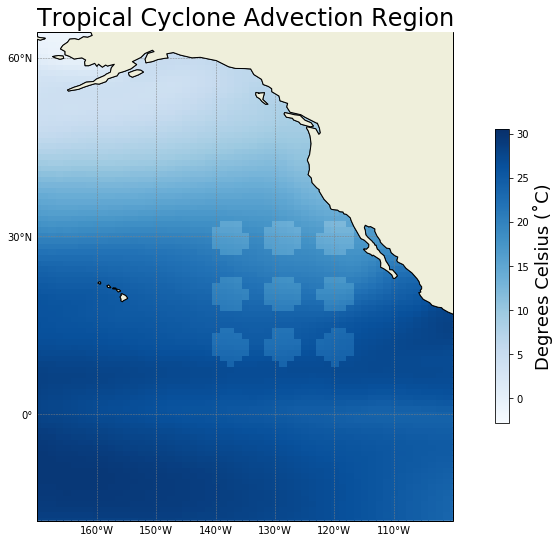

In [7]:
## Visualization Routine ##

#------------------------Package Loading----------------------------------#
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER 
import matplotlib.ticker as mticker
def add_latlon_ticks(ax):
# Adapted from http://scitools.org.uk/cartopy/docs/v0.13/matplotlib/gridliner.html
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0.5, color='gray', linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylocator = mticker.FixedLocator(np.arange(-90,91,30))
#-------------------------------------------------------------------------#


#--------------------------User Input-------------------------------------#
file_num = 1
#-------------------------------------------------------------------------#


plt.figure(4)
format_num = '{:03d}'.format(file_num)
mod_surf = xr_open('{0}_{1}.nc'\
                                  .format(new_file_name,format_num))[var[1]].isel(time=timeslice)

lon_b = np.linspace(0, 360, 288)
lat_b = np.linspace(-90, 90,192) 
fig = plt.figure(figsize=[15,9])
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cft.LAND, zorder=100, edgecolor='k')
ax.coastlines()
add_latlon_ticks(ax)
ax.set_extent([190, 260, -15,60])
plt.pcolormesh(lon_b, lat_b, mod_surf, cmap='Blues')
cb = plt.colorbar(shrink=0.6)
plt.title('Tropical Cyclone Advection Region', fontsize=24)
cb.set_label(cbtitle,fontsize=18)
